In [90]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)

eSOH_DIR = "../data/esoh_V/"
oCV_DIR = "../data/ocv/"
fig_DIR = "../figures/figures_sens/"
res_DIR = "../data/results_sens/"

In [91]:
parameter_values = get_parameter_values()

In [92]:
cell = 22
# cell = 23

In [93]:
cell_no,dfe,N = load_data_calendar(cell,eSOH_DIR)

Cycle Numbers:
0.0, 25.2705671642907, 93.0685096180532, 130.029355057864, 168.119850242976, 204.058473101817, 245.030302534695


In [94]:
# C_n_init,C_p_init,x_init,y_init,c_rate_c,c_rate_d,dis_set = init_exp(cell_no,dfe)
C_n_init,C_p_init,SOC_0 = init_exp_calendar(cell_no,dfe)

In [108]:
pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")
calendar_time = 24
experiment = pybamm.Experiment(
    [
        ("Rest for "+f'{calendar_time}'+" hours",)
    ]*250 ,
    termination="50% capacity",
#     cccv_handling="ode",
)
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        # "loss of active material": ("stress-driven","none"),
        "loss of active material": "stress-driven",
        # "stress-induced diffusion": "true",
        # "lithium plating": "reversible",
    }
)
# spm.print_parameter_info()

In [109]:
param = spm.param
eps_n_data = parameter_values.evaluate(C_n_init*3600/(param.n.L * param.n.c_max * param.F* param.A_cc))
eps_p_data = parameter_values.evaluate(C_p_init*3600/(param.p.L * param.p.c_max * param.F* param.A_cc))
# cs_p_init = parameter_values.evaluate(y_0_init* param.c_p_max)

In [110]:
Temp = [25,45,-5]
k_sei = [1,1/1.5,1.5,1/2,2,1/3,3,1/10,10]
# d_sei = [1,1/1.5,1.5,1/2,2,1/3,3,1/10,100]
d_sei = [1,1e-1,1e1,1e-2,1e2,1e-3,1e3,1e-4,1e4]

In [111]:
ksei_idx = 0
dsei_idx = 0
Temp_idx = 2

In [112]:
parameter_values = get_parameter_values()

parameter_values.update(
    {
        "SEI kinetic rate constant [m.s-1]": 1.6827e-16*k_sei[ksei_idx], #1.6827e-16
        # "Positive electrode LAM constant proportional term [s-1]": 4.20e-06, #4.03536e-06
        # "Negative electrode LAM constant proportional term [s-1]": 5.38e-05, #5.24755e-05
        "Positive electrode LAM constant proportional term [s-1]": 5e-3/3600,
        "Negative electrode LAM constant proportional term [s-1]": 4.3e-2/3600,
        "EC diffusivity [m2.s-1]": 2e-18*d_sei[dsei_idx],
        "Positive electrode LAM constant exponential term": 2,
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        # "Initial concentration in positive electrode [mol.m-3]": y_init*c_p_max,
        # "Initial concentration in negative electrode [mol.m-3]": x_init*c_n_max,
        "Initial temperature [K]": 273.15+Temp[Temp_idx],
        "Ambient temperature [K]": 273.15+Temp[Temp_idx],
        "SEI growth activation energy [J.mol-1]": 5000,
    },
    check_already_exists=False,
)

In [113]:
parameter_values.search("SEI")

Initial inner SEI thickness [m]	2.5e-09
Initial outer SEI thickness [m]	2.5e-09
Inner SEI electron conductivity [S.m-1]	8.95e-14
Inner SEI lithium interstitial diffusivity [m2.s-1]	1e-20
Inner SEI open-circuit potential [V]	0.1
Inner SEI partial molar volume [m3.mol-1]	9.585e-05
Inner SEI reaction proportion	0.5
Outer SEI open-circuit potential [V]	0.8
Outer SEI partial molar volume [m3.mol-1]	9.585e-05
Outer SEI solvent diffusivity [m2.s-1]	2.5000000000000002e-22
Ratio of lithium moles to SEI moles	2.0
SEI growth activation energy [J.mol-1]	5000
SEI kinetic rate constant [m.s-1]	1.6827e-16
SEI open-circuit potential [V]	0.4
SEI reaction exchange current density [A.m-2]	1.5e-07
SEI resistivity [Ohm.m]	200000.0


In [114]:
all_sumvars_dict = cycle_adaptive_simulation(spm, parameter_values, experiment,SOC_0, save_at_cycles=1)

In [115]:
# fig = plotc(all_sumvars_dict,dfe);
# plt.savefig(fig_DIR +'calendar_aging_cell_'+cell_no+'_eSOH.png')

In [116]:
Temp_idx = 1

In [117]:
parameter_values.update(
        {
            "SEI kinetic rate constant [m.s-1]": 1.6827e-16*k_sei[ksei_idx], #1.6827e-16
            "Positive electrode LAM constant proportional term [s-1]": 5e-3/3600,
            "Negative electrode LAM constant proportional term [s-1]": 4.3e-2/3600,
            "EC diffusivity [m2.s-1]": 2e-18*d_sei[dsei_idx],
            "Initial temperature [K]": 273.15+Temp[Temp_idx],
            "Ambient temperature [K]": 273.15+Temp[Temp_idx],
        },
        check_already_exists=False,
    )

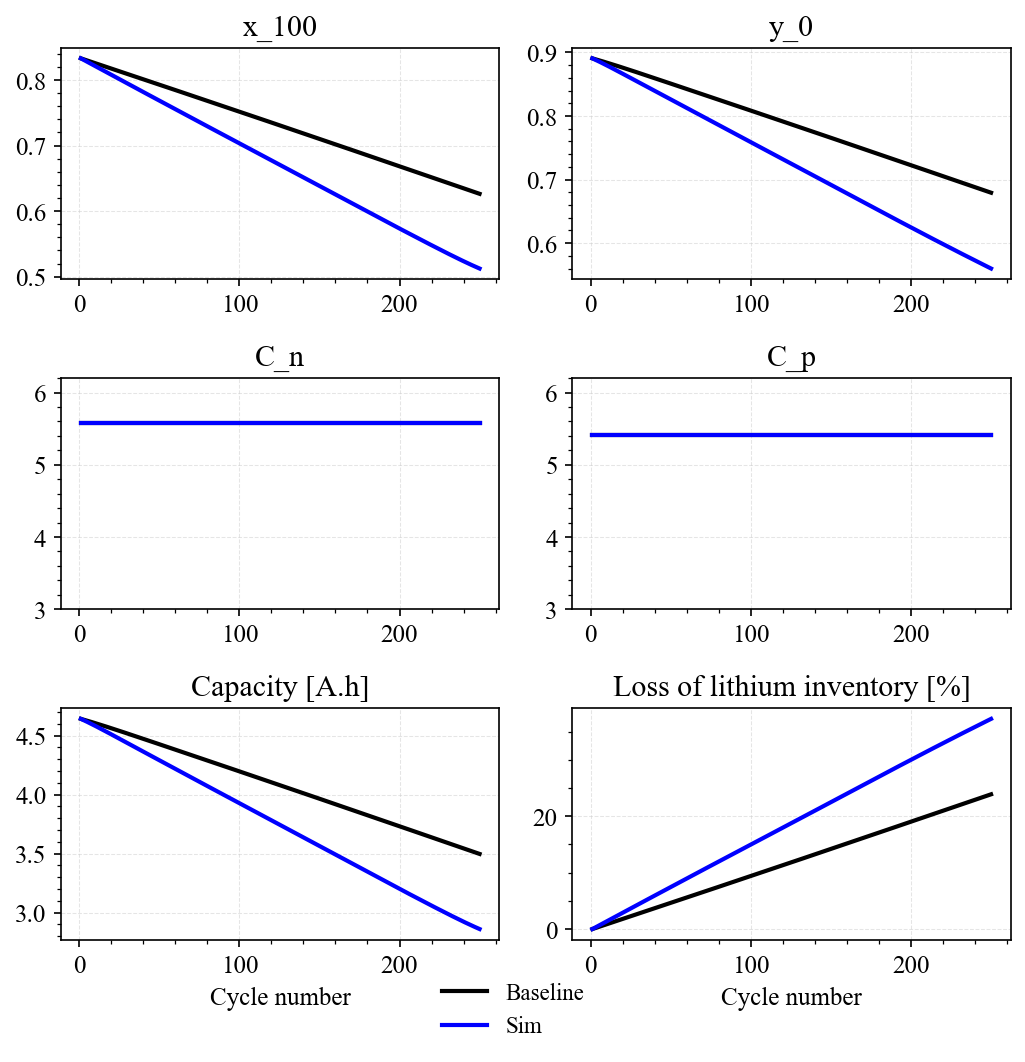

In [118]:
all_sumvars_dict_1 = cycle_adaptive_simulation(spm, parameter_values, experiment,SOC_0, save_at_cycles=1)
fig = plotcomp(all_sumvars_dict,all_sumvars_dict_1);

In [119]:
parameter_values.search("SEI growth")

SEI growth activation energy [J.mol-1]	5000


In [120]:
parameter_values.search("temperature")

Ambient temperature [K]	318.15
Initial temperature [K]	318.15
Reference temperature [K]	298.15


## Parameter Fitting

In [ ]:
def plot_comp(all_sumvars_dict_0,all_sumvars_dict_1,esoh_data):
    esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]
    esoh_data["Capacity [A.h]"]=esoh_data["Cap"]
    param = pybamm.LithiumIonParameters()
    esoh_data["n_Li"]= 3600/param.F.value*(esoh_data["y_100"]*esoh_data["C_p"]+esoh_data["x_100"]*esoh_data["C_n"])
    esoh_data["Loss of lithium inventory [%]"]=(1-esoh_data["n_Li"]/esoh_data["n_Li"][0])*100
    fig, axes = plt.subplots(3,2,figsize=(7,7))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict_1["Cycle number"],all_sumvars_dict_1[name],"bo")
        ax.plot(all_sumvars_dict_0["Cycle number"],all_sumvars_dict_0[name],"ro")
        # ax.plot(all_sumvars_dict_1["Cycle number"],all_sumvars_dict_1[name],"bo")
        ax.plot(esoh_data["N"],esoh_data[name],"kx")
        ax.axvline(x = all_sumvars_dict_0["Cycle number"][-1], color = 'm', label = 'axvline - full height')
        ax.set_title(split_long_string(name))
        if k>3:
            ax.set_xlabel("Cycle number")
    fig.legend(["Pred"]+["Train"] + ["Data"], 
           loc="lower center",bbox_to_anchor=[0.5, -0.05], ncol=1, fontsize=11)
    fig.tight_layout()
    return fig

In [ ]:
def objective(model, data):
    return np.array(model.loc[data['N_mod']]["Capacity [A.h]"]) - np.array(data["Cap"])

def multi_objective(model, data):
    variables = ["C_n","C_p","x_100","y_0"]
    # variables = ["Capacity [A.h]", "C_n"]
    weights = [1,1,5,5]
    return np.concatenate([
        (np.array(model.loc[data['N_mod']][var]) - np.array(data[var])) * w
        for w,var in zip(weights,variables)
    ]
    )
@timeoutable()
def simulate(x,expt):
    parameter_values = get_parameter_values()
    parameter_values.update(
        {
            "SEI kinetic rate constant [m.s-1]":  x[2]*k_sei[ic],
            "Positive electrode LAM constant proportional term [s-1]": x[0]* blam_p[ic],
            "Negative electrode LAM constant proportional term [s-1]": x[1]*blam_n[ic],
            "EC diffusivity [m2.s-1]": 2e-18,
            "Positive electrode LAM constant exponential term": 2,
            "Negative electrode LAM constant exponential term": 2,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
        },
        check_already_exists=False,
    )
    Cn = parameter_values.evaluate(param.C_n_init)
    Cp = parameter_values.evaluate(param.C_p_init)
    eps_n = parameter_values["Negative electrode active material volume fraction"]
    eps_p = parameter_values["Positive electrode active material volume fraction"]
    C_over_eps_n = Cn / eps_n
    C_over_eps_p = Cp / eps_p
    return cycle_adaptive_simulation(spm, parameter_values, expt,save_at_cycles=1)
def prediction_error(x,data,expt):
    try:
        model = simulate(x,expt,timeout=60)
        out = multi_objective(pd.DataFrame(model), data)
        print(f"x={x}, norm={np.linalg.norm(out)}")
    # except pybamm.SolverError:
    except:
        out = 10*np.ones_like(np.concatenate([np.array(data['Cap'])]*4))
        print(f"x={x}, norm={np.linalg.norm(out)}")
        return out
    return out
def train_model(data,expt):
    timer = pybamm.Timer()
    x0 = np.array([1.0,1.0,1.0])
    # print(prediction_error(x0))
    soln_dfols = dfols.solve(prediction_error, x0,args=(data,expt), rhoend=1e-3)
    print(timer.time())
    return soln_dfols
def sim_train(dfe,experiment,df,train_len):
    data_train = dfe.iloc[:train_len]
    experiment_train = pybamm.Experiment(
        [
            ("Discharge at "+c_rate_d+dis_set,
            "Rest for 5 min",
            "Charge at "+c_rate_c+" until 4.2V", 
            "Hold at 4.2V until C/50")
        ] *data_train.N.iloc[-1],
        termination="50% capacity",
    #     cccv_handling="ode",
    )
    soln_dfols = train_model(data_train,experiment_train)
    xsol = soln_dfols.x
    # print(xsol[0]*2e-2/3600)
    # print(xsol[1]*2e-1/3600)
    # print(xsol[2]*1.6e-16)
    df['train_len'][train_len-3]=train_len
    df['x_0'][train_len-3]=round(xsol[0],4)
    df['x_1'][train_len-3]=round(xsol[1],4)
    df['x_2'][train_len-3]=round(xsol[2],4)
    # df['obj'][train_len-3]=soln_dfols.f
    try:
        sol_out = simulate(soln_dfols.x,experiment_train,timeout = 60)
        sol_full = simulate(soln_dfols.x,experiment,timeout = 60)
        df['obj'][train_len-3]= np.linalg.norm(prediction_error(soln_dfols.x,data_train,experiment_train))
        df['obj_full'][train_len-3] = np.linalg.norm(prediction_error(soln_dfols.x,dfe,experiment))
        fig = plot_comp(sol_out,sol_full,dfe);
        return df,fig
    except:
        print("Train Len = "+str(train_len)+" failed")
        fig, axes = plt.subplots(3,2,figsize=(7,7))
        return df,fig

In [ ]:
def objective(model, data):
    return np.array(model.loc[data['N_mod']]["Capacity [A.h]"]) - np.array(data["Cap"])

def multi_objective(model, data):
    variables = ["C_n","C_p","x_100","y_0"]
    # variables = ["Capacity [A.h]", "C_n"]
    weights = [1,1,5,5]
    return np.concatenate([
        (np.array(model.loc[data['N_mod']][var]) - np.array(data[var])) * w
        for w,var in zip(weights,variables)
    ]
    )
@timeoutable()
def simulate(x,expt):
    parameter_values = get_parameter_values()
    parameter_values.update(
        {
            "SEI kinetic rate constant [m.s-1]":  x[2]*k_sei[ic],
            "Positive electrode LAM constant proportional term [s-1]": x[0]* blam_p[ic],
            "Negative electrode LAM constant proportional term [s-1]": x[1]*blam_n[ic],
            "EC diffusivity [m2.s-1]": 2e-18,
            "Positive electrode LAM constant exponential term": 2,
            "Negative electrode LAM constant exponential term": 2,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
        },
        check_already_exists=False,
    )
    Cn = parameter_values.evaluate(param.C_n_init)
    Cp = parameter_values.evaluate(param.C_p_init)
    eps_n = parameter_values["Negative electrode active material volume fraction"]
    eps_p = parameter_values["Positive electrode active material volume fraction"]
    C_over_eps_n = Cn / eps_n
    C_over_eps_p = Cp / eps_p
    return cycle_adaptive_simulation(spm, parameter_values, expt,save_at_cycles=1)
def prediction_error(x,data,expt):
    try:
        model = simulate(x,expt,timeout=60)
        out = multi_objective(pd.DataFrame(model), data)
        print(f"x={x}, norm={np.linalg.norm(out)}")
    # except pybamm.SolverError:
    except:
        out = 10*np.ones_like(np.concatenate([np.array(data['Cap'])]*4))
        print(f"x={x}, norm={np.linalg.norm(out)}")
        return out
    return out
def train_model(data,expt):
    timer = pybamm.Timer()
    x0 = np.array([1.0,1.0,1.0])
    # print(prediction_error(x0))
    soln_dfols = dfols.solve(prediction_error, x0,args=(data,expt), rhoend=1e-3)
    print(timer.time())
    return soln_dfols
def sim_train(dfe,experiment,df,train_len):
    data_train = dfe.iloc[:train_len]
    # experiment_train = pybamm.Experiment(
    #     [
    #         ("Discharge at "+c_rate_d+dis_set,
    #         "Rest for 5 min",
    #         "Charge at "+c_rate_c+" until 4.2V", 
    #         "Hold at 4.2V until C/50")
    #     ] *data_train.N.iloc[-1],
    #     termination="50% capacity",
    # #     cccv_handling="ode",
    # )
    experiment_train=experiment
    soln_dfols = train_model(data_train,experiment_train)
    xsol = soln_dfols.x
    # print(xsol[0]*2e-2/3600)
    # print(xsol[1]*2e-1/3600)
    # print(xsol[2]*1.6e-16)
    df['train_len'][0]=train_len
    df['x_0'][0]=round(xsol[0],4)
    df['x_1'][0]=round(xsol[1],4)
    # df['x_2'][0]=round(xsol[2],4)
    df['obj'][0]=soln_dfols.f
    try:
        sol_out = simulate(soln_dfols.x,experiment_train,timeout = 60)
        sol_full = simulate(soln_dfols.x,experiment,timeout = 60)
        df['obj'][0]= np.linalg.norm(prediction_error(soln_dfols.x,data_train,experiment_train))
        df['obj_full'][0] = np.linalg.norm(prediction_error(soln_dfols.x,dfe,experiment))
        fig = plot_comp(sol_out,sol_full,dfe);
        return df,fig
    except:
        print("Train Len = "+str(train_len)+" failed")
        fig, axes = plt.subplots(3,2,figsize=(7,7))
        return df,fig

In [ ]:
sim_des = "cell_"+cell_no
timer1 = pybamm.Timer()
train_len = len(N)
# for train_len in range(3,len(N)):
print("Train Length = {0}".format(train_len))
df_x,fig = sim_train(dfe,experiment,df_x,train_len)